In [24]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy import stats
from skimage.draw import line
from scipy.signal import chirp, find_peaks, peak_widths
from matplotlib import rcParams
import imageio

# The Sharpening Function

In [31]:
def sharpening_function(directory, x1, y1, x2, y2):  
    
    filenames = os.listdir(directory)

    grey_img = []
    sharpened_img_data = []
    
    fwhm_f3 = []
    fwhm_f4 = []
    fwhm_f5 = []
    fwhm_f6 = []
    fwhm_f7 = []

    for filename in sorted(filenames):
        if filename.endswith('.jpeg'):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            grey_img.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        
    for img in grey_img:

        for n in range(3,8):   #iterates through different sized low pass filters, 3x3 up until 7x7

            ###############
            #sharpen image#
            ###############
        
            low_pass_kernel =  np.ones((n,n),np.float32)/(n^2)
            blurred_img = cv2.filter2D(img,-1,low_pass_kernel)
            sharpened_img = img - blurred_img
        
            ########################################
            #calculate new fwhm and number of peaks#
            ########################################
        
            #draw a line using coordinate inputs from user
            height, width = sharpened_img.shape

            pixel_row = []
            pixel_value = []  
            rr, cc = line(y2, x2, y1, x1)   #returns the rows and columns of every coordinate in the line
            pixel_row.append(rr)
            pixel_value.append(255 - sharpened_img[rr, cc])        
            y = pixel_value[0]
        
            # Find the peaks and FWHM of resultant pixel values
            peaks, properties = find_peaks(y, prominence=2, width=10)   #prominence and width can be changed depending on how sensitive you want the peak detector to be
            properties["prominences"], properties["widths"]
            max_peak = np.amax(y[peaks])
            
            # Applying certain sized filters can cause the graph to invert, if so, need to invert it back. The threshold will also change depending on the image. 
            if max_peak < 200:
                pix_val_1 = []
                pix_val_1.append(sharpened_img[rr, cc])
                y_updated = pix_val_1[0]
            elif max_peak > 200:
                pix_val_2 = []
                pix_val_2.append(255 - sharpened_img[rr, cc])
                y_updated = pix_val_2[0]
        
            #find fwhm and number of peaks again using updated y values
            FWHM = []
            peaks, properties = find_peaks(y_updated, prominence=2, width=10)
            properties["prominences"], properties["widths"]
            new_no_of_peaks = len(peaks)
            fwhm = peak_widths(y, peaks, rel_height=0.5)
            FWHM.append(fwhm)
        
            #finally obtain values we want
            new_FWHM = np.amax(FWHM)
            new_no_of_peaks = len(peaks)

            #######################################
            #add values to array to call for later#
            #######################################

            sharpened_img_data.append(np.array([n, sharpened_img, new_FWHM, new_no_of_peaks]))  
        
        fwhm_f3.append((sharpened_img_data[0])[2])
        fwhm_f4.append((sharpened_img_data[1])[2])
        fwhm_f5.append((sharpened_img_data[2])[2])
        fwhm_f6.append((sharpened_img_data[3])[2])
        fwhm_f7.append((sharpened_img_data[4])[2])


    #######################
    #calculate optimised n#
    #######################

    y_3 = np.array(fwhm_f3)
    y_4 = np.array(fwhm_f4)
    y_5 = np.array(fwhm_f5)
    y_6 = np.array(fwhm_f6)
    y_7 = np.array(fwhm_f7)

    y_length = len(y_3)
    image_number = list(range(0,y_length))
    x = np.array(image_number)
        
    ##################################
    #find and remove outliers in data#
    ##################################

    z_3 = np.abs(stats.zscore(y_3))
    outliers_3 = (np.where(z_3 > 2))
    outliers_3_y = np.array(y_3[outliers_3])
    outliers_3_x = np.array(outliers_3) +50
    fwhm_f3_x = [ele for ele in x if ele not in outliers_3_x] 
    fwhm_f3_y = [ele for ele in y_3 if ele not in outliers_3_y]

    z_4 = np.abs(stats.zscore(y_4))
    outliers_4 = (np.where(z_4 > 2))
    outliers_4_y = np.array(y_4[outliers_4])
    outliers_4_x = np.array(outliers_4) +50
    fwhm_f4_x = [ele for ele in x if ele not in outliers_4_x]
    fwhm_f4_y = [ele for ele in y_4 if ele not in outliers_4_y]

    z_5 = np.abs(stats.zscore(y_5))
    outliers_5 = (np.where(z_5 > 1.3))
    outliers_5_y = np.array(y_5[outliers_5])
    outliers_5_x = np.array(outliers_5) +50
    fwhm_f5_x = [ele for ele in x if ele not in outliers_5_x]
    fwhm_f5_y = [ele for ele in y_5 if ele not in outliers_5_y]

    z_6 = np.abs(stats.zscore(y_6))
    outliers_6 = (np.where(z_6 > 2))
    outliers_6_y = np.array(y_6[outliers_6])
    outliers_6_x = np.array(outliers_6) +50
    fwhm_f6_x = [ele for ele in x if ele not in outliers_6_x]
    fwhm_f6_y = [ele for ele in y_6 if ele not in outliers_6_y]
    
    z_7 = np.abs(stats.zscore(y_7))
    outliers_7 = (np.where(z_7 > 2))
    outliers_7_y = np.array(y_7[outliers_7])
    outliers_7_x = np.array(outliers_7) +50
    fwhm_f7_x = [ele for ele in x if ele not in outliers_7_x]
    fwhm_f7_y = [ele for ele in y_7 if ele not in outliers_7_y]
        
    ##############################
    #get best fit for fwhm values#
    ##############################
        
    Polynomial = np.polynomial.Polynomial

    #3
    xmin_3, xmax_3 = min(fwhm_f3_x), max(fwhm_f3_x)
    pfit_3, stats_3 = Polynomial.fit(fwhm_f3_x, fwhm_f3_y, 1, full=True, window=(xmin_3, xmax_3),
                                                    domain=(xmin_3, xmax_3))
    y0_3, m_3 = pfit_3
    resid_3, rank_3, sing_val_3, rcond_3 = stats_3
    rms_3 = np.sqrt(resid_3[0]/len(fwhm_f3_y))

    #4
    xmin_4, xmax_4 = min(fwhm_f4_x), max(fwhm_f4_x)
    pfit_4, stats_4 = Polynomial.fit(fwhm_f4_x, fwhm_f4_y, 1, full=True, window=(xmin_4, xmax_4),
                                                    domain=(xmin_4, xmax_4))
    y0_4, m_4 = pfit_4
    resid_4, rank_4, sing_val_4, rcond_4 = stats_4
    rms_4 = np.sqrt(resid_4[0]/len(fwhm_f4_y))

    #5
    xmin_5, xmax_5 = min(fwhm_f5_x), max(fwhm_f5_x)
    pfit_5, stats_5 = Polynomial.fit(fwhm_f5_x, fwhm_f5_y, 1, full=True, window=(xmin_5, xmax_5),
                                                    domain=(xmin_5, xmax_5))
    y0_5, m_5 = pfit_5
    resid_5, rank_5, sing_val_5, rcond_5 = stats_5
    rms_5 = np.sqrt(resid_5[0]/len(fwhm_f5_y))

    #6
    xmin_6, xmax_6 = min(fwhm_f6_x), max(fwhm_f6_x)
    pfit_6, stats_6 = Polynomial.fit(fwhm_f6_x, fwhm_f6_y, 1, full=True, window=(xmin_6, xmax_6),
                                                    domain=(xmin_6, xmax_6))

    y0_6, m_6 = pfit_6
    resid_6, rank_6, sing_val_6, rcond_6 = stats_6
    rms_6 = np.sqrt(resid_6[0]/len(fwhm_f6_y))
    
    #7
    xmin_7, xmax_7 = min(fwhm_f7_x), max(fwhm_f7_x)
    pfit_7, stats_7 = Polynomial.fit(fwhm_f7_x, fwhm_f7_y, 1, full=True, window=(xmin_7, xmax_7),
                                                    domain=(xmin_7, xmax_7))

    y0_7, m_7 = pfit_7
    resid_7, rank_7, sing_val_7, rcond_7 = stats_7
    rms_7 = np.sqrt(resid_7[0]/len(fwhm_f7_y))

    ########################
    #find optimised n value#
    ########################
        
    avg_3 = np.mean(pfit_3(x))
    avg_4 = np.mean(pfit_4(x))
    avg_5 = np.mean(pfit_5(x))
    avg_6 = np.mean(pfit_6(x))
    avg_7 = np.mean(pfit_7(x))
        
    array = (avg_3,avg_4,avg_5,avg_6,avg_7)
        
    max_value = None
    max_idx = None

    for idx, num in enumerate(array):
        if (max_value is None or num > max_value):
            max_value = num
            max_idx = idx
            
    optimised_n = max_idx+3
    
    print('optimised n is: {}'.format(optimised_n))

    #######################################
    #sharpen all images using this n value#
    #######################################
    optimised_images = []

    for img in grey_img:
    
        updated_kernel =  np.ones((optimised_n,optimised_n),np.float32)/(optimised_n^2)
        blurred_image = cv2.filter2D(img,-1,updated_kernel)
        optimised_img = img - blurred_image
        optimised_images.append(optimised_img)
    
    return grey_img, optimised_images

# User Inputs

In [32]:
##############################################################################
#User Inputs: Choose directory of images and coordinates of line across image#
##############################################################################

directory = '/Users/hattiebishop/Focusing Project/Images/OnionEpidermis200nm'

#coordinates should draw a line perpendicular to a feature in the image for best results
x1 = 2447
y1 = 0
x2 = 1000
y2 = 2200


# Apply the Algorithm

<ipython-input-31-2842d2b46388>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sharpened_img_data.append(np.array([n, sharpened_img, new_FWHM, new_no_of_peaks]))
<ipython-input-31-2842d2b46388>:66: PeakPropertyWarning: some peaks have a prominence of 0
  fwhm = peak_widths(y, peaks, rel_height=0.5)
<ipython-input-31-2842d2b46388>:66: PeakPropertyWarning: some peaks have a width of 0
  fwhm = peak_widths(y, peaks, rel_height=0.5)


optimised n is: 5


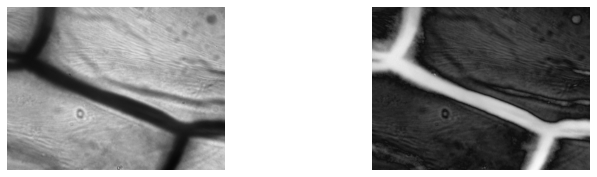

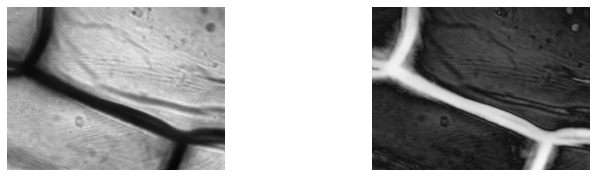

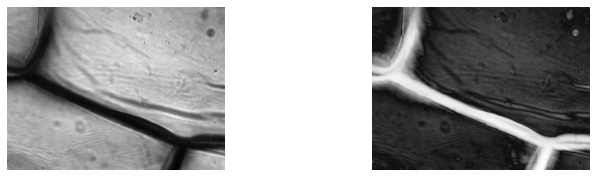

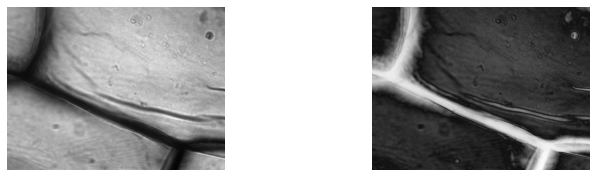

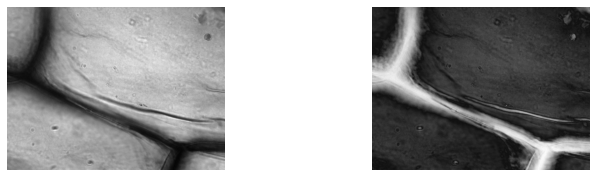

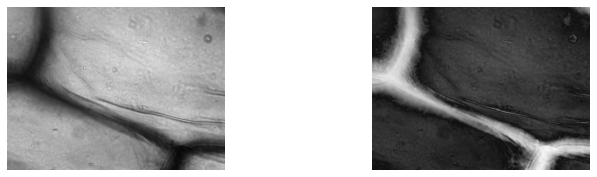

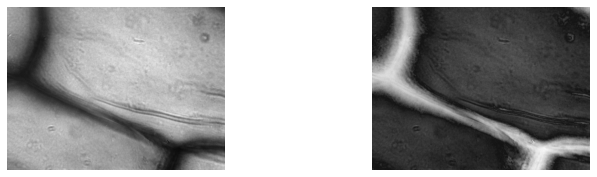

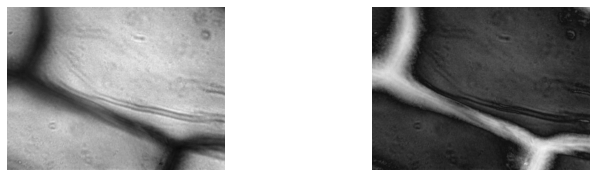

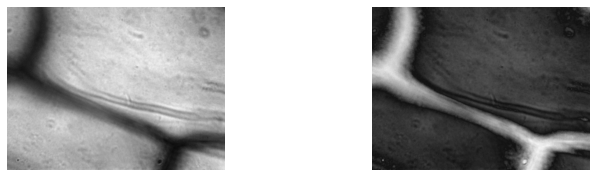

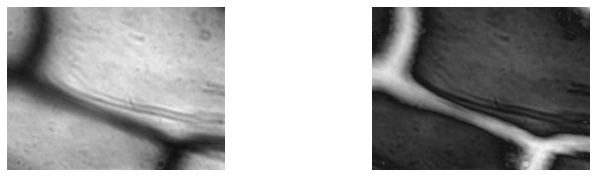

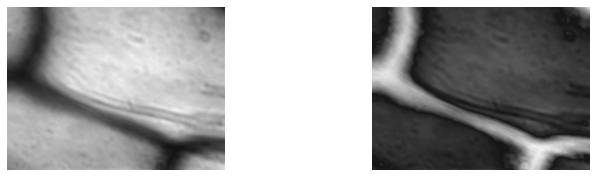

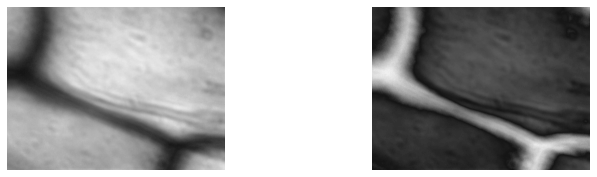

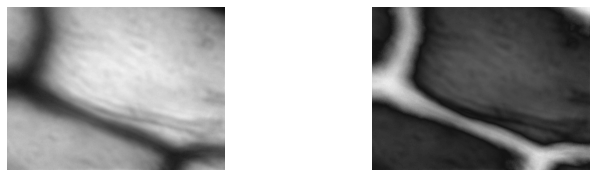

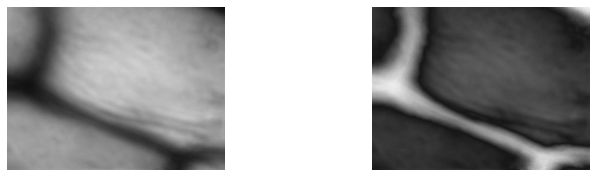

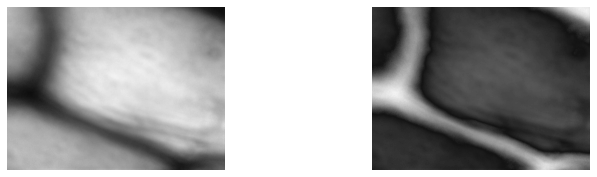

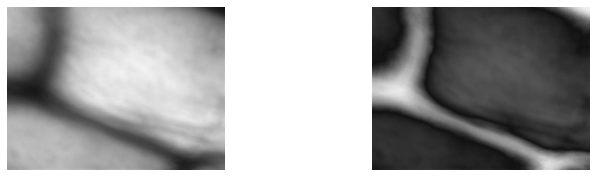

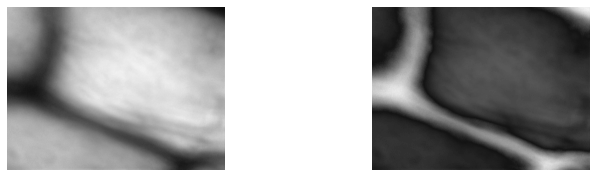

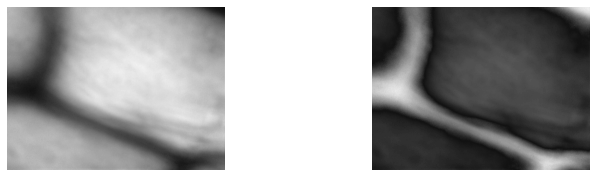

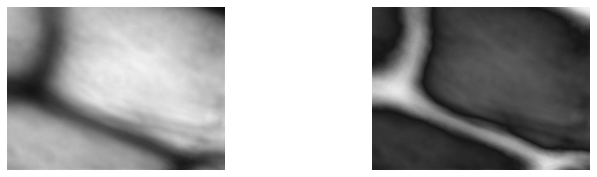

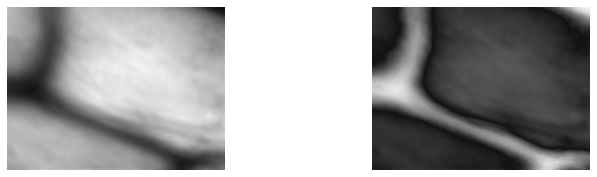

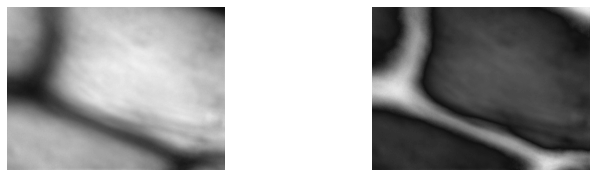

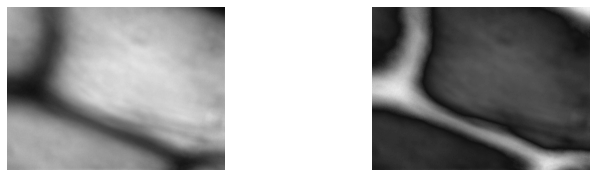

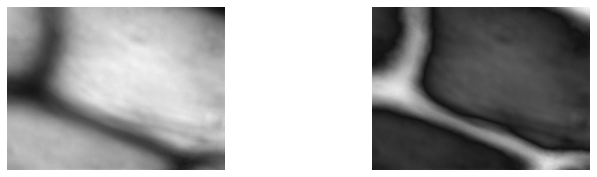

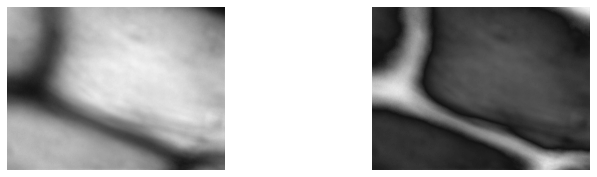

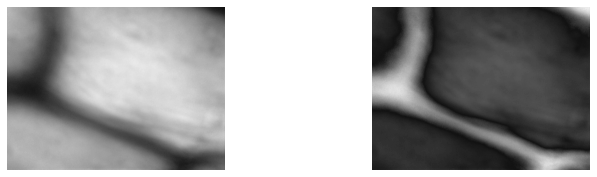

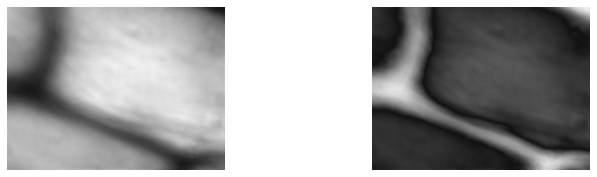

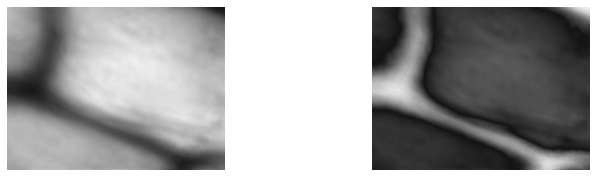

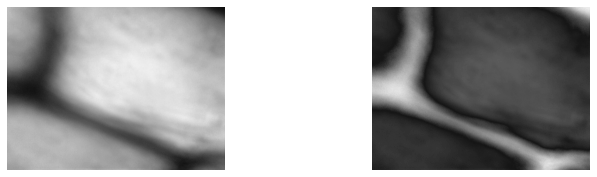

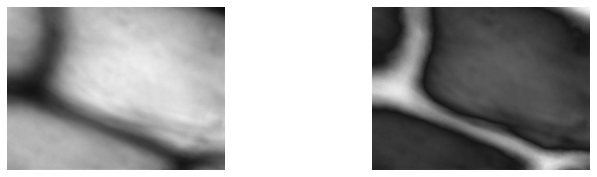

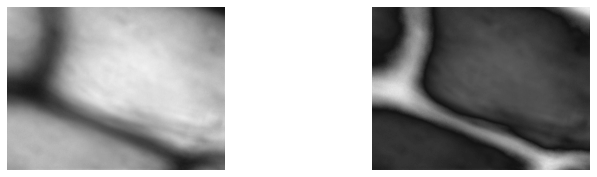

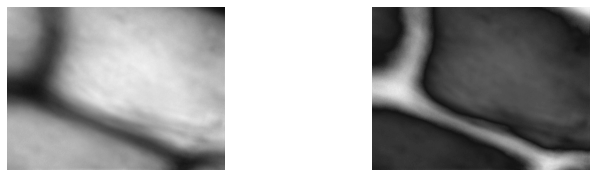

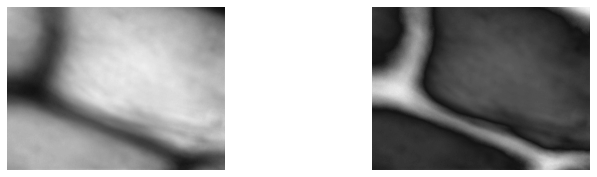

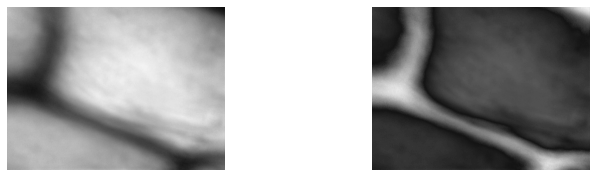

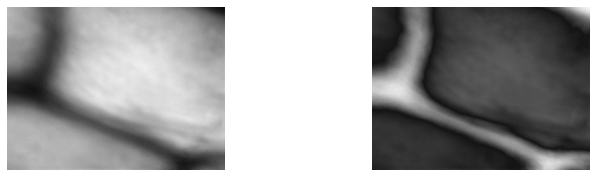

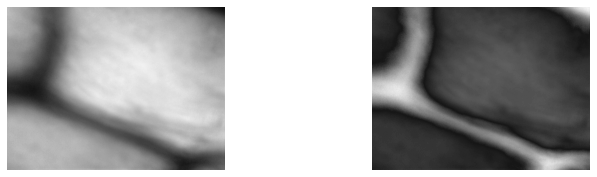

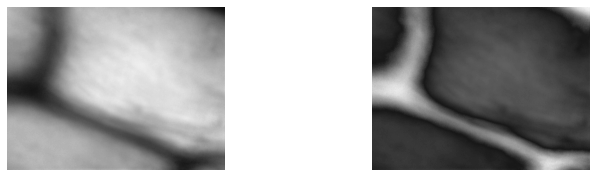

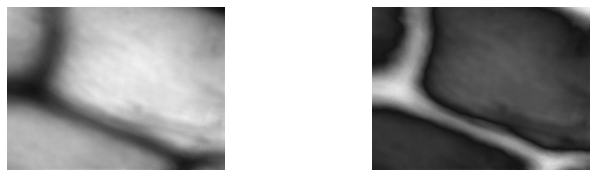

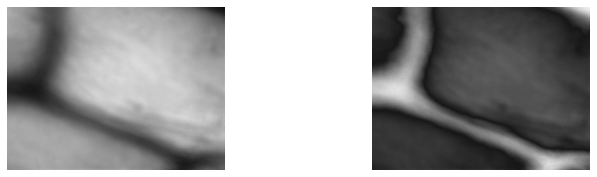

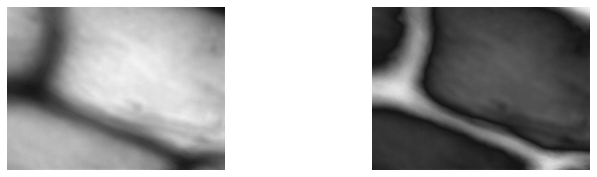

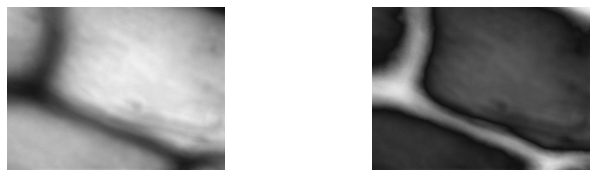

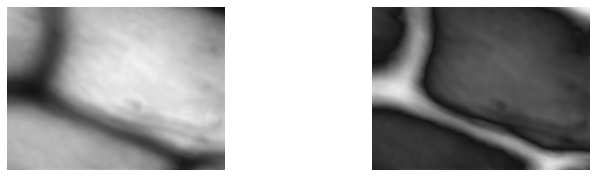

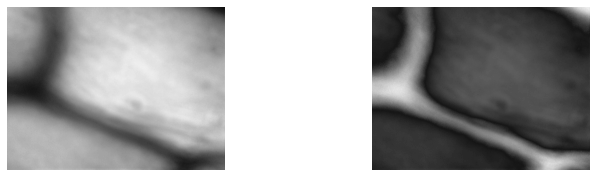

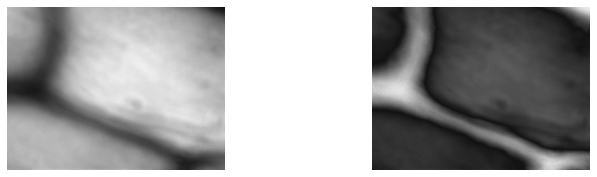

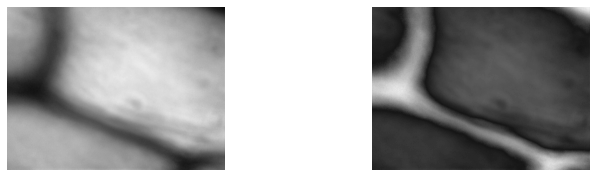

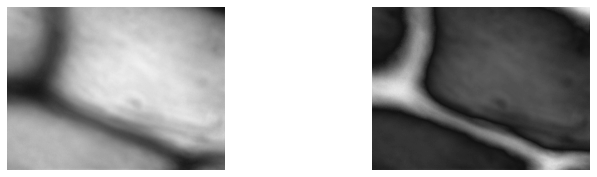

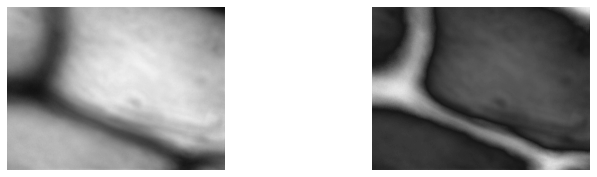

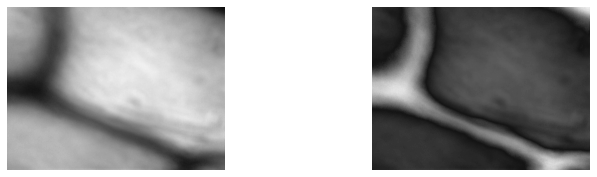

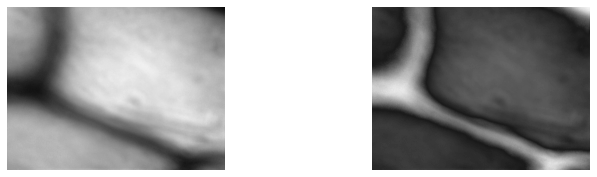

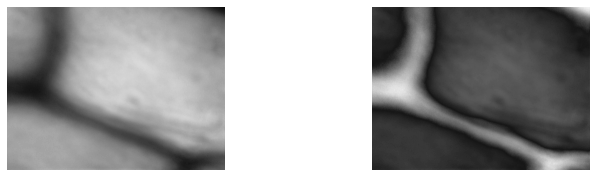

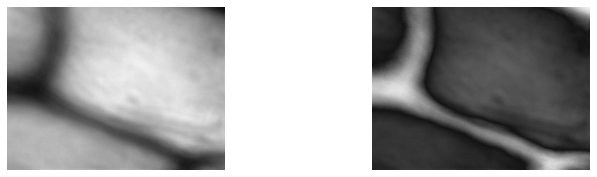

In [33]:
grey_img, optimised_images = sharpening_function(directory, x1, y1, x2, y2)

filenames = os.listdir(directory)
number_of_images = len(filenames)

for i in range(0,50):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(grey_img[i], cmap = 'gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(optimised_images[i], cmap = 'gray')
    plt.axis('off')
    
    plt.show()